In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")
import acquire
import prepare
import explore
import wrangle_store

In [2]:
df = acquire.get_store_data()

In [3]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.sale_date)).\
            sort_values('ds').\
            assign(dollars_sold = df.sale_amount * df.item_price).\
            assign(items_sold = df.sale_amount).\
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum().\
            reset_index().set_index('ds')

df = prep_data(df)

df = df[df.index != '2016-02-29']

In [4]:

train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [5]:
train.shape, validate.shape, test.shape
print(len(train) + len(validate) + len(test) == len(df))

True


In [6]:
print(df.head(1) == train.head(1))

                           dollars_sold  items_sold
ds                                                 
2013-01-01 00:00:00+00:00          True        True


In [7]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,dollars_sold,items_sold
ds,,
2016-12-30 00:00:00+00:00,120033.64,22296.0
2016-12-31 00:00:00+00:00,128009.31,23792.0


In [8]:
pd.concat([test.tail(1), df.tail(1)])

,dollars_sold,items_sold
ds,,
2017-12-31 00:00:00+00:00,140905.74,26420.0
2017-12-31 00:00:00+00:00,140905.74,26420.0


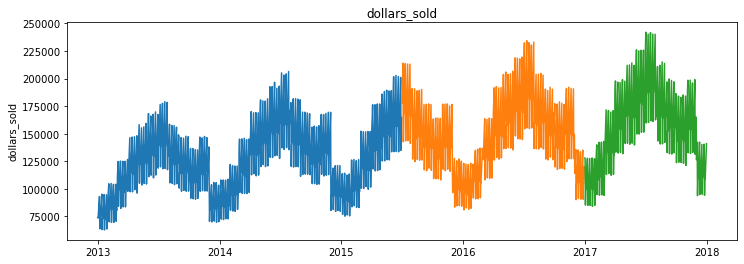

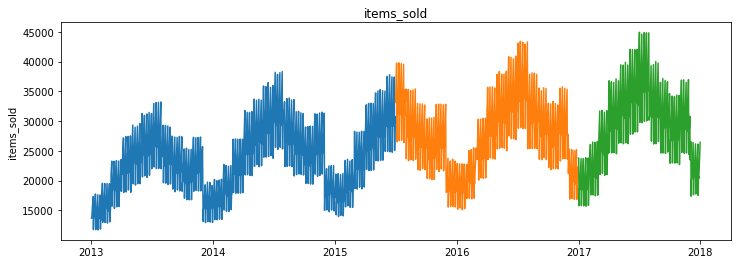

In [9]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [10]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [11]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [12]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [13]:
eval_df

,model_type,target_var,rmse


#### Last Observed Value

In [14]:
dollars = round(train['dollars_sold'][-1:][0], 2)
items = train['items_sold'][-1:][0]

In [15]:
yhat_df = pd.DataFrame({'dollars_sold': [dollars], 'items_sold': items}, index = validate.index)
yhat_df.head()

,dollars_sold,items_sold
ds,,
2015-07-02 00:00:00+00:00,164573.2,30703.0
2015-07-03 00:00:00+00:00,164573.2,30703.0
2015-07-04 00:00:00+00:00,164573.2,30703.0
2015-07-05 00:00:00+00:00,164573.2,30703.0
2015-07-06 00:00:00+00:00,164573.2,30703.0


dollars_sold -- RMSE: 35402


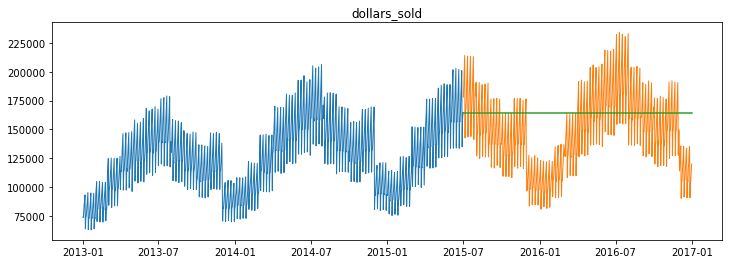

items_sold -- RMSE: 6621


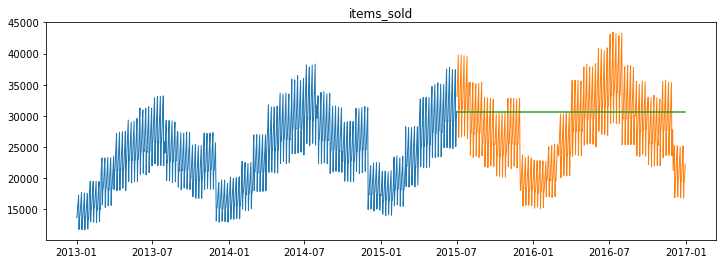

In [16]:
for col in train.columns:
    plot_and_eval(col)

In [17]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [18]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0


#### Simple Average

In [19]:
items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'items_sold': [items],
                            'dollars_sold': [dollars],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [20]:
yhat_df.tail()

,items_sold,dollars_sold
ds,,
2016-12-26 00:00:00+00:00,23717.94,127517.85
2016-12-27 00:00:00+00:00,23717.94,127517.85
2016-12-28 00:00:00+00:00,23717.94,127517.85
2016-12-29 00:00:00+00:00,23717.94,127517.85
2016-12-30 00:00:00+00:00,23717.94,127517.85


dollars_sold -- RMSE: 39664


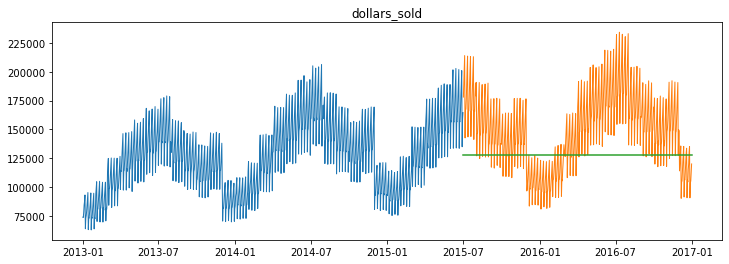

items_sold -- RMSE: 7378


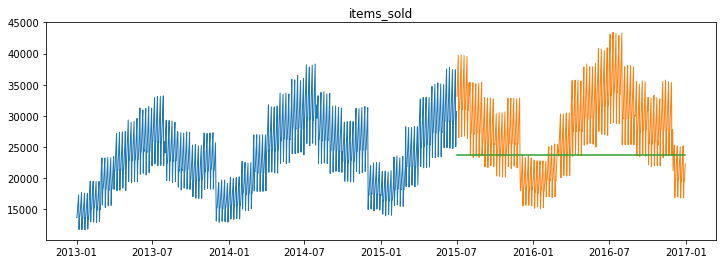

In [21]:
for col in train.columns:
    plot_and_eval(col)

In [22]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0


#### 30 day moving average

In [23]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

items = round(train['items_sold'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,31432.77,168957.91
2015-07-03 00:00:00+00:00,31432.77,168957.91
2015-07-04 00:00:00+00:00,31432.77,168957.91


dollars_sold -- RMSE: 37378


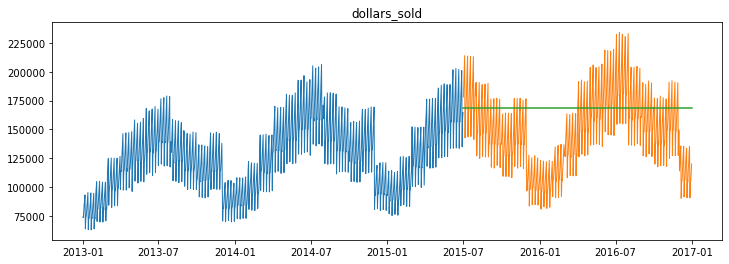

items_sold -- RMSE: 6954


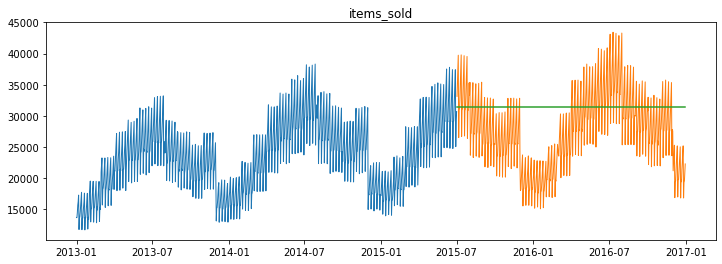

In [24]:
for col in train.columns:
    plot_and_eval(col)

In [25]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'rolling_30', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,rolling_30,dollars_sold,37378.0
5,rolling_30,items_sold,6954.0


In [26]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    items = round(train['items_sold'].rolling(p).mean()[-1], 2)
    dollars = round(train['dollars_sold'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'items_sold'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'dollars_sold'
                            )

In [27]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,rolling_30,dollars_sold,37378.0
5,rolling_30,items_sold,6954.0
6,1d moving average,items_sold,6621.0
7,1d moving average,dollars_sold,35402.0
8,4d moving average,items_sold,6592.0
9,4d moving average,dollars_sold,35515.0


In [28]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
16,104d moving average,items_sold,6101.0
17,104d moving average,dollars_sold,32803.0


#### Holt's Linear Trend
- smoothing applied to both the average and the trend(slope)
- weighted average applied to average, gives greater weight to recent values
- smoothing slope gives greater weight to recent slope/values

alpha = smoothing applied to average
beta = smooting applied to slope



dollars_sold 



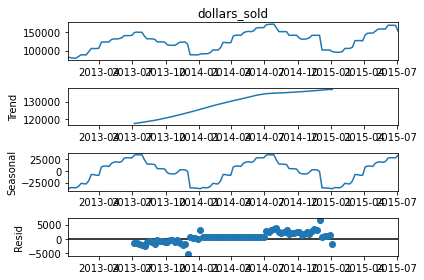

items_sold 



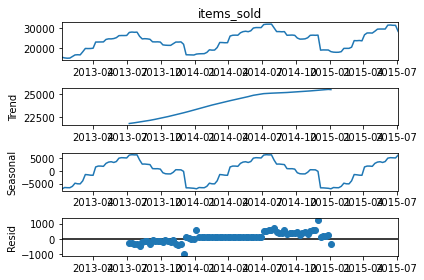

In [29]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions.

Holt:

exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit:

smoothing_level (
α
): value between (0,1)      
smoothing_slope (
β
): value between (0,1)     

In [30]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(
                      optimized = True)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [31]:
yhat_df

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,31805.37,171009.91
2015-07-03 00:00:00+00:00,31841.16,171202.04
2015-07-04 00:00:00+00:00,31876.96,171394.18
2015-07-05 00:00:00+00:00,31912.75,171586.31
2015-07-06 00:00:00+00:00,31948.55,171778.45
...,...,...
2016-12-26 00:00:00+00:00,51241.78,275339.34
2016-12-27 00:00:00+00:00,51277.58,275531.47
2016-12-28 00:00:00+00:00,51313.37,275723.61


dollars_sold -- RMSE: 84496


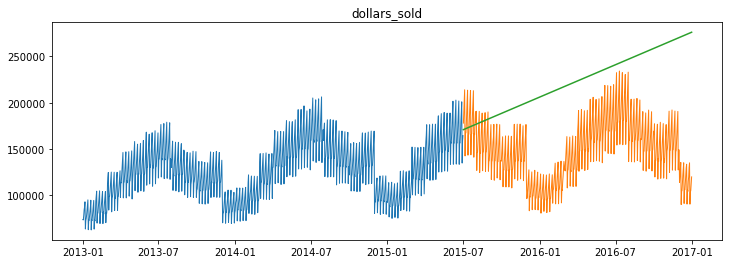

items_sold -- RMSE: 15727


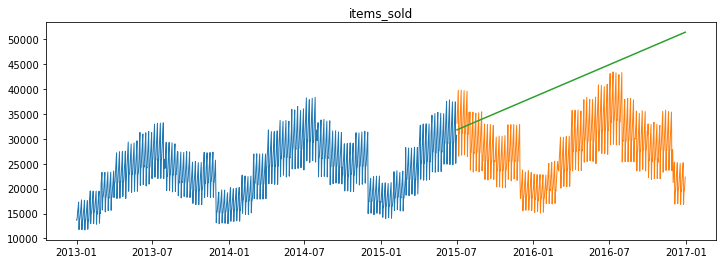

In [32]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [33]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts-optimized', 
                             target_var = col)

In [34]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,rolling_30,dollars_sold,37378.0
5,rolling_30,items_sold,6954.0
6,1d moving average,items_sold,6621.0
7,1d moving average,dollars_sold,35402.0
8,4d moving average,items_sold,6592.0
9,4d moving average,dollars_sold,35515.0


In [51]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

dollars_sold -- RMSE: 34700


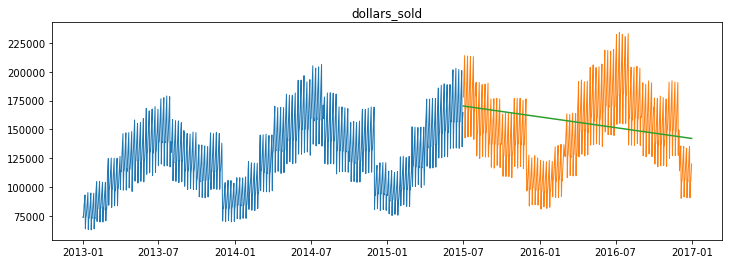

items_sold -- RMSE: 6464


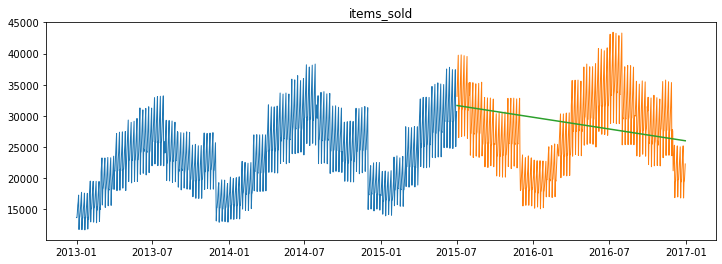

In [52]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [53]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [54]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,rolling_30,dollars_sold,37378.0
5,rolling_30,items_sold,6954.0
6,1d moving average,items_sold,6621.0
7,1d moving average,dollars_sold,35402.0
8,4d moving average,items_sold,6592.0
9,4d moving average,dollars_sold,35515.0


#### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day.

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence.

In the below example:
1. Compute the 365 average year over year differences from 2013 through 2015 2. Add that average delta to the values during 2015. 3. Set the index in your yhat dataframe to represent the dates those predictions are make for.

Let's get started....

In [55]:
# resplit data
train = df[:'2015']
validate = df['2016']
test = df['2017']
# make predictions
yhat_df = train['2015'] + train.diff(365).mean()

In [56]:
# take a peek into the prediction we will make for 2016 vs act 2016
pd.concat([yhat_df.head(1), validate.head(1)])

,dollars_sold,items_sold
ds,,
2015-01-01 00:00:00+00:00,104337.620493,19411.813699
2016-01-01 00:00:00+00:00,107875.260000,20158.000000


In [57]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

365

dollars_sold -- RMSE: 28087


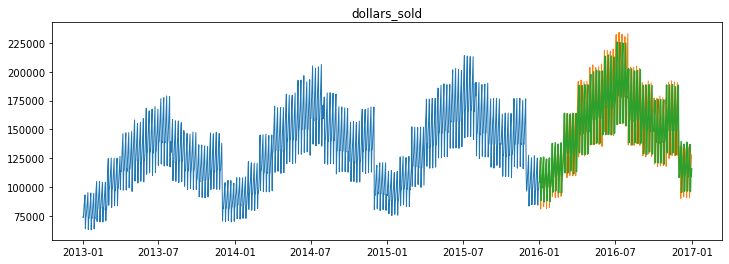

items_sold -- RMSE: 5223


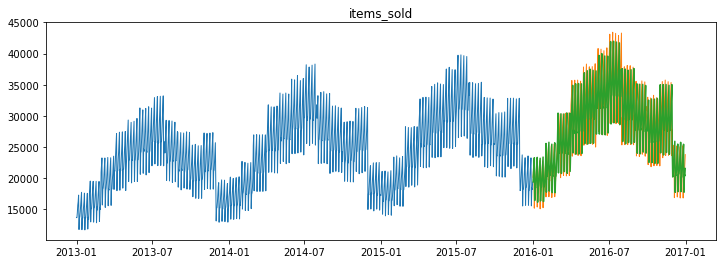

In [58]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [59]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,rolling_30,dollars_sold,37378.0
5,rolling_30,items_sold,6954.0
6,1d moving average,items_sold,6621.0
7,1d moving average,dollars_sold,35402.0
8,4d moving average,items_sold,6592.0
9,4d moving average,dollars_sold,35515.0


In [60]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
22,previous year,dollars_sold,28087.0
23,previous year,items_sold,5223.0


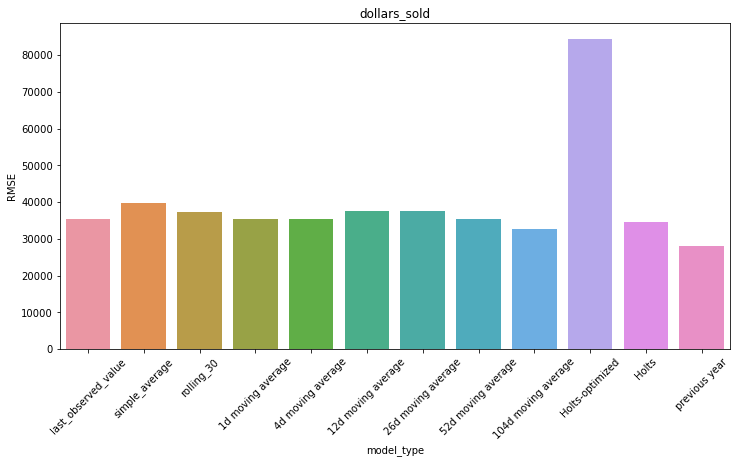

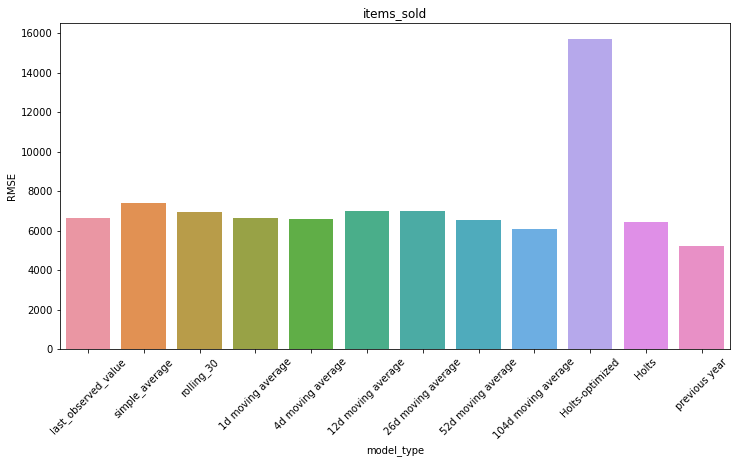

In [61]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

#### Test with previous year

In [62]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [63]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label = 'validate')
    plt.plot(test[target_var], label = 'test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [64]:
rmse_dollars = sqrt(mean_squared_error(test['dollars_sold'], yhat_df['dollars_sold']))
rmse_items = sqrt(mean_squared_error(test['items_sold'], yhat_df['items_sold']))

In [65]:
print('rmse_dollars=', rmse_dollars)
print('rmse_items=', rmse_items)

rmse_dollars= 27114.786014988113
rmse_items= 5040.989142541608


In [66]:
# to predict 2018

yhat_df = test + train.diff(365).mean()
yhat_df.index = test.index + pd.Timedelta('1Y')

In [67]:
yhat_df.head()

,dollars_sold,items_sold
ds,,
2018-01-01 05:49:12+00:00,139013.960493,25894.813699
2018-01-02 05:49:12+00:00,97081.230493,17957.813699
2018-01-03 05:49:12+00:00,112140.900493,20835.813699
2018-01-04 05:49:12+00:00,111205.840493,20695.813699
2018-01-05 05:49:12+00:00,119365.050493,22080.813699


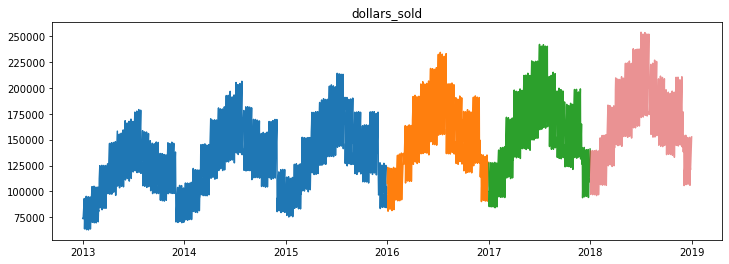

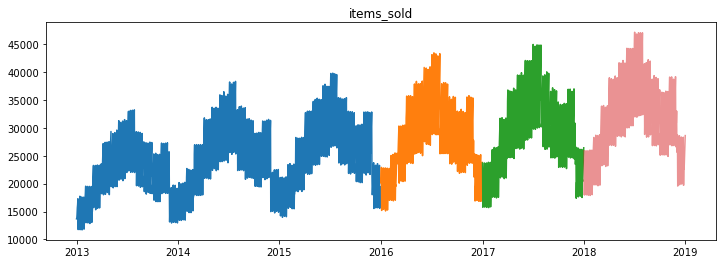

In [68]:
for col in train.columns:
    final_plot(col)